## **Importing Modules.**

In [3]:
import os
import numpy as np
import re
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from PIL import Image
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers

## **Downloading Butterfly Datasets.**

In [4]:
# Create a directory for Kaggle API and move kaggle.json there
os.makedirs("/root/.kaggle", exist_ok=True)

# Move kaggle.json to the correct location
os.rename("kaggle.json", "/root/.kaggle/kaggle.json")

# Set correct permissions
os.chmod("/root/.kaggle/kaggle.json", 600)

# Install Kaggle API if not installed
!pip install -q kaggle

# Download the dataset
!kaggle datasets download -d veeralakrishna/butterfly-dataset

# Unzip the dataset
!unzip -q butterfly-dataset.zip -d butterfly_dataset

# Verify the dataset
!ls butterfly_dataset


Dataset URL: https://www.kaggle.com/datasets/veeralakrishna/butterfly-dataset
License(s): Community Data License Agreement - Permissive - Version 1.0
100% 453M/454M [00:22<00:00, 24.2MB/s]
100% 454M/454M [00:22<00:00, 21.6MB/s]
leedsbutterfly


In [5]:
# setting the path to the dataset directories.
image_path = "/content/butterfly_dataset/leedsbutterfly/images"
mask_path = "/content/butterfly_dataset/leedsbutterfly/segmentations"

In [6]:
# Listing images and corresponding image mask.
images = os.listdir(image_path)
masks  = os.listdir(mask_path)

# Displaying the statistics of the image dataset and their mask dataset.
print(f"The Data Statistics \nimages: {len(images)} masks: {len(masks)}")

The Data Statistics 
images: 832 masks: 832


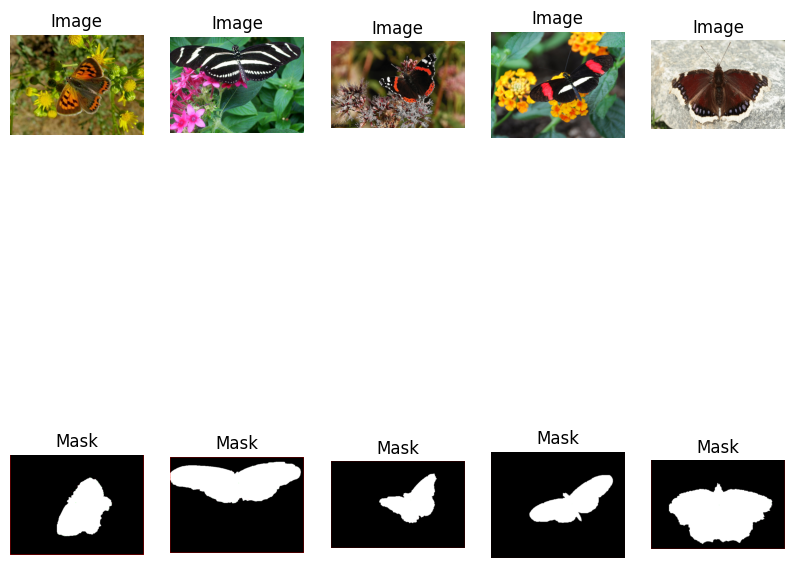

In [7]:
# Function to find the corresponding masks for a given image.
def get_corresponding_mask(image_name):
    base_name = image_name.split('.')[0] # Extract base name (e.g., '0010001')
    mask_name = f"{base_name}_seg0.png" # Append '_seg0' to match the patterns.
    return mask_name

# Display a few sample images and their corresponding masks.
def show_samples(image_list, num_samples=3):
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        img = Image.open(os.path.join(image_path, image_list[i]))
        mask_name = get_corresponding_mask(image_list[i])
        mask = Image.open(os.path.join(mask_path, mask_name))

        plt.subplot(2, num_samples, i+1)
        plt.imshow(img)
        plt.title("Image")
        plt.axis("off")

        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.imshow(mask)
        plt.title("Mask")
        plt.axis("off")

    plt.show()

show_samples(images, num_samples=5)

## **Load Data.**

In [8]:
# Function to load and preprocess the dataset.
def load_data(image_dir, mask_dir, image_shape=256):
    """
    Loads and preprocessees images and masks for training.
    Args:
        * image_dir (str): Directory containing images.
        * mask_dir (str): Directory containing masks.
        * image_shape (int, optional): Shape to resize the images and masks. Defaults to 256.
    Returns:
        * tuple: Arrays of preprocessed images and masks.
    """
    # storing the images and masks before converting into the NumPy arrays.
    image_list = []
    mask_list = []

    image_names = os.listdir(image_dir)
    mask_names = [re.sub(r"\.png", "_seg0.png", name) for name in image_names]

    for image_name, mask_name in zip(image_names, mask_names):
        try:
            img = plt.imread(os.path.join(image_dir, image_name))
            mask = plt.imread(os.path.join(mask_dir, mask_name))
        except FileNotFoundError:
            print("Exception happened as the file is not found.")
            continue

        # Resizing the images and masks.
        image_resized = cv2.resize(img, (image_shape, image_shape))
        mask_resized = cv2.resize(mask, (image_shape, image_shape))

        # storing the preprocessed data.
        image_list.append(image_resized)
        mask_list.append(mask_resized[:, :, 0])

    return np.array(image_list), np.array(mask_list)

image_dir = "/content/butterfly_dataset/leedsbutterfly/images"
mask_dir = "/content/butterfly_dataset/leedsbutterfly/segmentations"
images, masks = load_data(image_dir, mask_dir)

In [9]:
images.shape, masks.shape

((832, 256, 256, 3), (832, 256, 256))

## **Dividing Datasets into Training, Testing & Validation.**

In [10]:
# Split the data into training and validation data.
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

In [11]:
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(665, 256, 256, 3) (167, 256, 256, 3) (665, 256, 256) (167, 256, 256)


## **Building an uNET Architecture.**

### **Building Convolution Block.**

In [12]:
# function to create an convolutional block for the U-Net Model.

def convolutional_block(input_tensor, num_filters, kernel_size=3, use_batch_norm=True):
    """
    Args:
        input_tensor (tensor): Input to the convolutional block.
        num_filters (int): Number of filters for the convolutional layers.
        kernel_size (int, optional): size of the convolution kernel. Default is 3.
        use_batch_norm (boo, optional): Apply batch normalization if True. Defaults to True.
    Returns:
        tensor: Output after applying convolution, batch normalization, and activation.
    """
    # First Convolution.
    x = layers.Conv2D(filters=num_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal", padding="same")(input_tensor)

    if use_batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    # Second Convolution.
    x = layers.Conv2D(filters=num_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal", padding="same")(x)

    if use_batch_norm:
        x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    return x

### **Building an UNET Model.**

In [13]:
# Function to create a U-NET Model.
def build_unet(input_shape, num_filters=16, dropout_rate=0.1, use_batch_norm=True):
    """
    Args:
        input_shape (tuple): Shape of the input image (height, width, channels)
        num_filters (int, optional): Number of filters for the initial layers. Default to 16.
        dropout_rate (float, optional): Dropout rate for regualarization. Defaults to 0.1
        use_batch_norm (bool, optional): Apply batch normalization if True. Defaults to True.
    Returns:
        keras.Model: Compiled U-Net Model.
    """
    inputs = layers.Input(input_shape)

    # Encoder Path.
    c1 = convolutional_block(inputs, num_filters*1, use_batch_norm=use_batch_norm)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    p1 = layers.Dropout(dropout_rate)(p1)

    c2 = convolutional_block(p1, num_filters*2, use_batch_norm=use_batch_norm)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    p2 = layers.Dropout(dropout_rate)(p2)

    c3 = convolutional_block(p2, num_filters*4, use_batch_norm=use_batch_norm)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    p3 = layers.Dropout(dropout_rate)(p3)

    c4 = convolutional_block(p3, num_filters*8, use_batch_norm=use_batch_norm)
    p4 = layers.MaxPooling2D((2, 2))(c4)
    p4 = layers.Dropout(dropout_rate)(p4)


    # Bottleneck.
    c5 = convolutional_block(p4, num_filters*16, use_batch_norm=use_batch_norm)

    # Decoder Path.
    u6 = layers.Conv2DTranspose(num_filters*8, (3, 3), strides=(2, 2), padding="same")(c5)
    u6 = layers.concatenate([u6, c4])
    u6 = layers.Dropout(dropout_rate)(u6)
    c6 = convolutional_block(u6, num_filters*8, use_batch_norm=use_batch_norm)

    u7 = layers.Conv2DTranspose(num_filters*4, (3, 3), strides=(2,2), padding="same")(c6)
    u7 = layers.concatenate([u7, c3])
    u7 = layers.Dropout(dropout_rate)(u7)
    c7 = convolutional_block(u7, num_filters*4, use_batch_norm=use_batch_norm)

    u8 = layers.Conv2DTranspose(num_filters * 2, (3, 3), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    u8 = layers.Dropout(dropout_rate)(u8)
    c8 = convolutional_block(u8, num_filters * 2, use_batch_norm=use_batch_norm)

    u9 = layers.Conv2DTranspose(num_filters * 1, (3, 3), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    u9 = layers.Dropout(dropout_rate)(u9)
    c9 = convolutional_block(u9, num_filters * 1, use_batch_norm=use_batch_norm)


    # Since we are not predicting any thing. so we are only using the Conv2D.
    output = layers.Conv2D(1, (1, 1), activation="sigmoid")(c9)

    # model creation.
    model = tf.keras.Model(inputs=[inputs], outputs=[output])

    return model

# Instantiate and compile the U-Net Model.
input_shape = (256, 256, 3)

unet_model = build_unet(input_shape, dropout_rate=0.07)

unet_model.compile(
    optimizer="Adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

unet_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 16)   │            448 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 256, 256, 16)   │             64 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 256, 256, 16)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 16)   │          2,320 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 256, 256, 16)   │             64 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 256, 256, 16)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 16)   │              0 │ activation_1[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128, 128, 16)   │              0 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 32)   │          4,640 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 128, 128, 32)   │            128 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 128, 128, 32)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 32)   │          9,248 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 128, 128, 32)   │            128 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 128, 128, 32)   │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 32)     │              0 │ activation_3[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)  

 Total params: 2,164,593 (8.26 MB)

 Trainable params: 2,161,649 (8.25 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [14]:
%%capture
!pip install visualkeras

/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


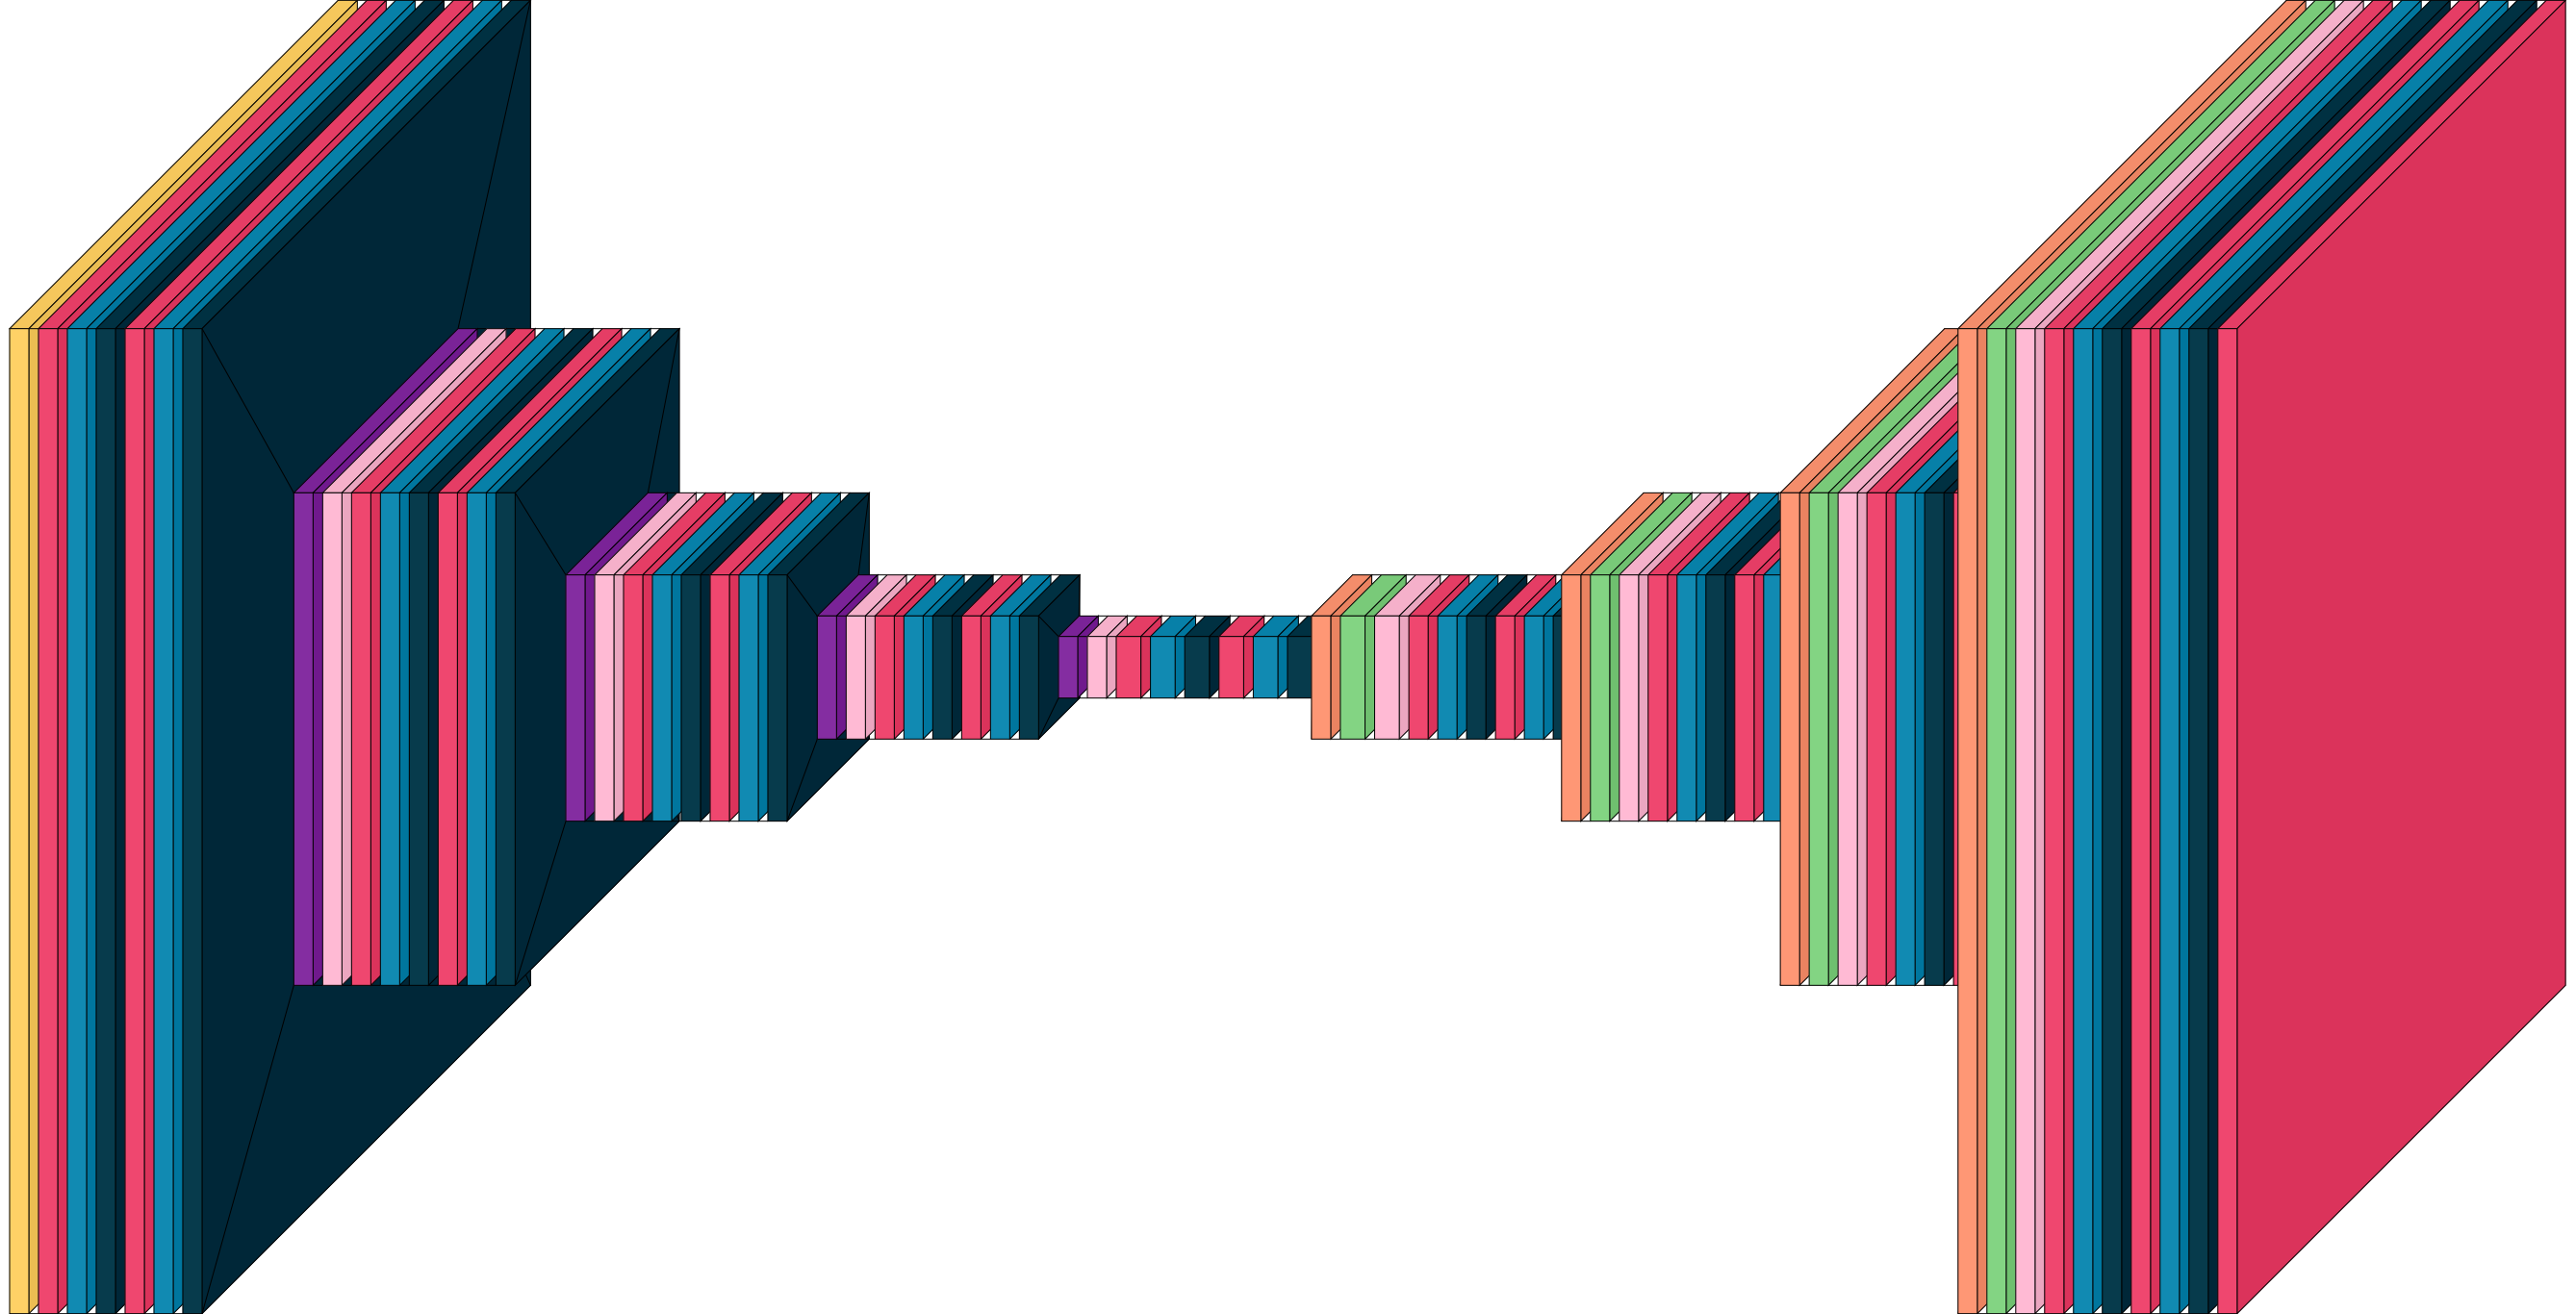

In [15]:
from visualkeras import layered_view
import visualkeras
visualkeras.layered_view(unet_model)

In [16]:
from tensorflow.keras.utils import plot_model
plot_model(unet_model, to_file='UnetArchitecture.png', show_shapes=True, show_layer_names=True)

"dot" with args ['-Tpng', '/tmp/tmp2n8jhcwk/tmp10nu1geq'] returned code: -6

stdout, stderr:
 b''
b"failed at node 3283[1]\ndot: maze.c:313: chkSgraph: Assertion `np->cells[1]' failed.\n"



AssertionError: "dot" with args ['-Tpng', '/tmp/tmp2n8jhcwk/tmp10nu1geq'] returned code: -6

### **Implementing the callbacks.**

In [17]:
# Callbacks.
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    verbose=1,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=5,
    verbose=1,
    min_lr=1e-6
)

model_checkpoint = ModelCheckpoint(
    "unet_model_best.keras",
    monitor="val_loss",
    save_best_only=-True,
    verbose=1
)

### **Training the model.**

In [18]:
history = unet_model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    verbose=1,
    callbacks=[
        early_stopping,
        reduce_lr,
        model_checkpoint
    ]
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6109 - loss: 0.6602   
Epoch 1: val_loss improved from inf to 9.41624, saving model to unet_model_best.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.6165 - loss: 0.6557 - val_accuracy: 0.3279 - val_loss: 9.4162 - learning_rate: 0.0010
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step - accuracy: 0.8763 - loss: 0.3770
Epoch 2: val_loss improved from 9.41624 to 5.33912, saving model to unet_model_best.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 336ms/step - accuracy: 0.8763 - loss: 0.3767 - val_accuracy: 0.5265 - val_loss: 5.3391 - learning_rate: 0.0010
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.8974 - loss: 0.3115
Epoch 3: val_loss improved from 5.33912 to 5.26167, saving model to unet_model_best.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 348ms/step - accuracy: 0.8975 - loss: 0.3112 - val_accuracy: 0.5138 - val_loss: 5.2617 - learning_rate: 0.0010
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 

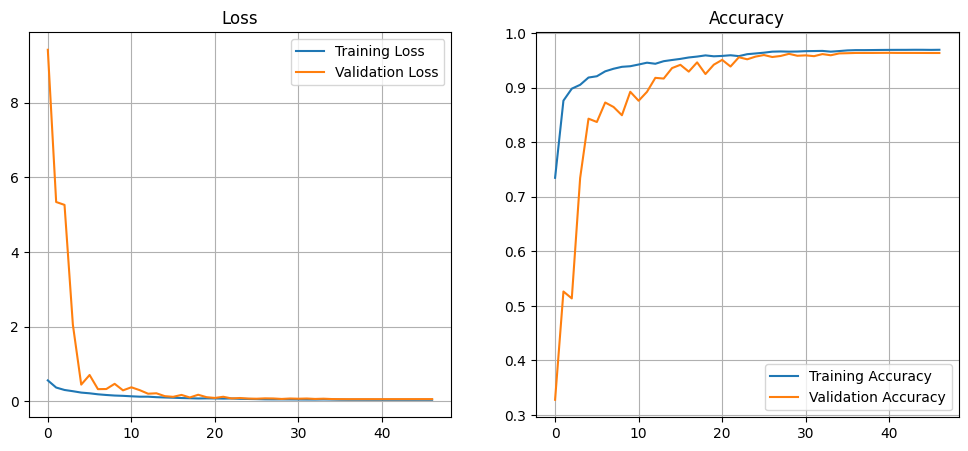

In [20]:
# Plot training and validation loss and accuracy.
def plot_train_val_loss_accuracy(history):

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.legend()
    plt.grid()
    plt.title("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(history.history["accuracy"], label="Training Accuracy")
    plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
    plt.legend()
    plt.grid()
    plt.title("Accuracy")
    plt.show()

plot_train_val_loss_accuracy(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Inference time for a single image: 0.1120 seconds


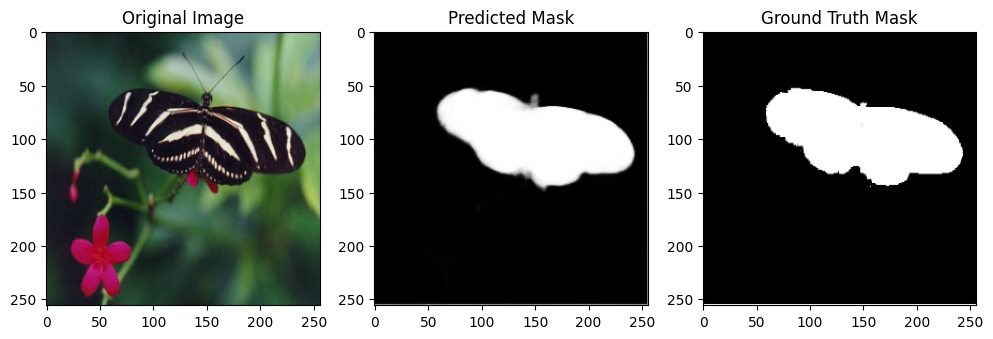

In [29]:
# Function to predict and time the inference for a single image
def predict_single_image(image, model):
    """
    Predicts the segmentation mask for a single image and times the prediction.

    Args:
        image (array): Input image for prediction.
        model (keras.Model): Trained U-Net model.

    Returns:
        tuple: Predicted mask and inference time.
    """
    start_time = time.time()
    prediction = model.predict(np.expand_dims(image, axis=0))[0, :, :, 0]
    end_time = time.time()
    inference_time = end_time - start_time

    return prediction, inference_time

# Function to visualize the prediction and ground truth
def visualize_segmentation(image, predicted_mask, ground_truth_mask):
    """
    Visualizes the original image, predicted mask, and ground truth mask.

    Args:
        image (array): Original image.
        predicted_mask (array): Predicted mask.
        ground_truth_mask (array): Ground truth mask.
    """
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title('Predicted Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(ground_truth_mask, cmap='gray')
    plt.title('Ground Truth Mask')

    plt.show()

# Example inference on a validation image
sample_image = X_val[0]
sample_ground_truth = y_val[0]

predicted_mask, inference_time = predict_single_image(sample_image, unet_model)
print(f'Inference time for a single image: {inference_time:.4f} seconds')

# Visualize the result
visualize_segmentation(sample_image, predicted_mask, sample_ground_truth)

### **Calculating Mean IOU (`Intersection Over Union`) Score.**

In [30]:
import tensorflow.keras.backend as K

def mean_iou(y_true, y_pred, smooth=1):
    """
    Calculate the mean intersection over union (IoU).
    Args:
        y_true (tensor): Ground truth Mask.
        y_pred (tensor): Predicted mask.
        smooth (float, optional): Smoothing factor to avoid division by zero. Defaults to 1.
    Returns:
        float: Mean IoU score.
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection

    return (intersection + smooth) / (union + smooth)

# Get predictions.
y_pred = unet_model.predict(X_val)
print(mean_iou(y_val, y_pred))

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 211ms/step
tf.Tensor(0.8747961, shape=(), dtype=float32)


In [31]:
# Get predictions
y_pred = unet_model.predict(X_train)
print(mean_iou(y_train,y_pred))

21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step
tf.Tensor(0.8984498, shape=(), dtype=float32)


In [33]:
import tensorflow.keras.backend as K

def dice_coefficient(y_true, y_pred, smooth=1):
    """
    Calculate the Dice coefficient.

    Args:
        y_true (tensor): Ground truth mask.
        y_pred (tensor): Predicted mask.
        smooth (float, optional): Smoothing factor to avoid division by zero. Defaults to 1.

    Returns:
        float: Dice coefficient score.
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def mean_iou(y_true, y_pred, smooth=1):
    """
    Calculate the mean Intersection over Union (IoU).

    Args:
        y_true (tensor): Ground truth mask.
        y_pred (tensor): Predicted mask.
        smooth (float, optional): Smoothing factor to avoid division by zero. Defaults to 1.

    Returns:
        float: Mean IoU score.
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

input_shape = (256, 256, 3)
unet_model = build_unet(input_shape, dropout_rate=0.07)

In [35]:
# Compile the U-Net model with Dice coefficient and mean IoU as metrics
unet_model.compile(optimizer='Adam', loss='binary_crossentropy',
                   metrics=['accuracy', dice_coefficient, mean_iou])

In [36]:
# Train the model with the additional metrics
history = unet_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, verbose=1)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_76']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


21/21 ━━━━━━━━━━━━━━━━━━━━ 52s 1s/step - accuracy: 0.4804 - dice_coefficient: 0.4316 - loss: 0.8459 - mean_iou: 0.2758 - val_accuracy: 0.2411 - val_dice_coefficient: 0.3981 - val_loss: 11.7690 - val_mean_iou: 0.2487
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 333ms/step - accuracy: 0.8341 - dice_coefficient: 0.4918 - loss: 0.5065 - mean_iou: 0.3264 - val_accuracy: 0.2432 - val_dice_coefficient: 0.3890 - val_loss: 10.6951 - val_mean_iou: 0.2417
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 325ms/step - accuracy: 0.8674 - dice_coefficient: 0.5484 - loss: 0.4037 - mean_iou: 0.3782 - val_accuracy: 0.5937 - val_dice_coefficient: 0.4443 - val_loss: 1.3449 - val_mean_iou: 0.2858
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 324ms/step - accuracy: 0.8929 - dice_coefficient: 0.6135 - loss: 0.3389 - mean_iou: 0.4429 - val_accuracy: 0.6325 - val_dice_coefficient: 0.5235 - val_loss: 2.8763 - val_mean_iou: 0.3548
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 323ms/step - accuracy: 0.9006 - dice_coefficient: 0.6389

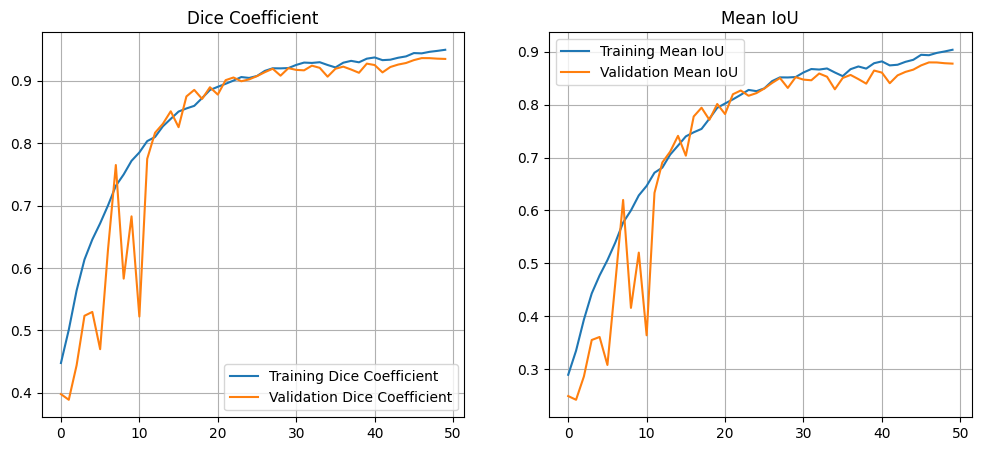

In [37]:
# Plot Dice coefficient and mean IoU during training and validation
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['dice_coefficient'], label='Training Dice Coefficient')
plt.plot(history.history['val_dice_coefficient'], label='Validation Dice Coefficient')
plt.legend()
plt.grid()
plt.title('Dice Coefficient')

plt.subplot(1, 2, 2)
plt.plot(history.history['mean_iou'], label='Training Mean IoU')
plt.plot(history.history['val_mean_iou'], label='Validation Mean IoU')
plt.legend()
plt.grid()
plt.title('Mean IoU')

plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_76']
Received: inputs=Tensor(shape=(1, 256, 256, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


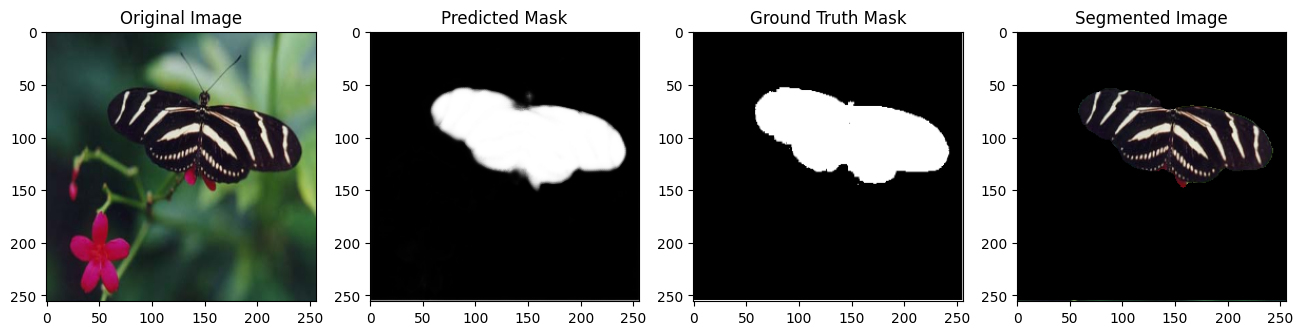

In [38]:
def visualize_segmentation_with_cropping(image, predicted_mask, ground_truth_mask):
    """
    Visualizes the original image, predicted mask, ground truth mask, and segmented image.

    Args:
        image (array): Original image.
        predicted_mask (array): Predicted mask.
        ground_truth_mask (array): Ground truth mask.
    """
    # Threshold the predicted mask to create a binary mask for segmentation
    binary_mask = (predicted_mask > 0.5).astype(np.uint8)

    # Plotting the original image, predicted mask, ground truth mask, and segmented image
    plt.figure(figsize=(16, 4))

    plt.subplot(1, 4, 1)
    plt.imshow(image)
    plt.title('Original Image')

    plt.subplot(1, 4, 2)
    plt.imshow(predicted_mask, cmap='gray')
    plt.title('Predicted Mask')

    plt.subplot(1, 4, 3)
    plt.imshow(ground_truth_mask, cmap='gray')
    plt.title('Ground Truth Mask')

    # Apply the binary mask to the original image to create the segmented output
    segmented_image = cv2.merge((binary_mask, binary_mask, binary_mask)) * image

    plt.subplot(1, 4, 4)
    plt.imshow(segmented_image)
    plt.title('Segmented Image')

    plt.show()

# Example usage
sample_image = X_val[0]
sample_ground_truth = y_val[0]

predicted_mask, _ = predict_single_image(sample_image, unet_model)

# Visualize the segmentation results with cropping
visualize_segmentation_with_cropping(sample_image, predicted_mask, sample_ground_truth)
